Change detection demos on ONERA dataset


[ps] possible next steps: https://github.com/isaaccorley/torchrs#onera-satellite-change-detection-oscd

In [1]:
#### [CONFIG] ####

# model training

epochs = 30

# dataset

tile_size = 64
#overlap = 0
overlap = 32

filter_enough_change = True
#change_pix_percent = 0.0 # has at least some change
#change_pix_percent = 0.1 # has at least 10% change (only 336 samples!)
change_pix_percent = 0.03 # has at least 3% change (1044 samples - might be actually good!)



**To Do:**


*   Load all bands
*   Better model (siamese unet)
*   Load all data and weigh change samples proportionally (? maybe can be done even with current losses?)
*   Augment with w/h flips and 90 degree rotations



In [2]:
!pip install kornia # plans for data augmentation
!pip install gdown # for downloading from gdrive
!pip install segmentation-models # models

# Versions from logs:
# \ Successfully installed kornia-0.6.2
# \ Successfully installed efficientnet-1.0.0 image-classifiers-1.0.0 keras-applications-1.0.8 segmentation-models-1.0.1

     |████████████████████████████████| 401 kB 5.4 MB/s 
     |████████████████████████████████| 50 kB 4.0 MB/s 


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math
import sklearn.metrics
# all ch loading:
import shutil
from glob import glob
from skimage import io

from tqdm import tqdm
from pprint import pprint

# 0 down

In [4]:
!mkdir OSCD
%cd OSCD

/content/OSCD


In [5]:
# Data downloading snippet by https://www.kaggle.com/ktncktnc/change-detection-training/notebook
import gdown

%cd /content/OSCD

# Uploaded to gdrive, but can also be downloaded from https://ieee-dataport.org/open-access/oscd-onera-satellite-change-detection
image_url = 'http://drive.google.com/uc?id=1us6Nr6KKRsqtx9dUVtYnRbJTKIwZIsdV'
train_lb_url = 'http://drive.google.com/uc?id=19bluw98KNjneqjNFXdxWqGYrYEtghRYF'
test_lb_url = 'http://drive.google.com/uc?id=1bPYTUiDL9--ejwK2Ebr6XtpgVHdiVcrZ'

image_output = "OSCD-image.zip"
train_output = "OSCD - Train Labels.zip"
test_output = "OSCD - Test Labels.zip"

gdown.download(train_lb_url, train_output, quiet=False)
gdown.download(test_lb_url, test_output, quiet=False)
gdown.download(image_url, image_output, quiet=False)

/content/OSCD


Downloading...
From: http://drive.google.com/uc?id=19bluw98KNjneqjNFXdxWqGYrYEtghRYF
To: /content/OSCD/OSCD - Train Labels.zip
100%|██████████| 138k/138k [00:00<00:00, 40.3MB/s]
Downloading...
From: http://drive.google.com/uc?id=1bPYTUiDL9--ejwK2Ebr6XtpgVHdiVcrZ
To: /content/OSCD/OSCD - Test Labels.zip
100%|██████████| 83.6k/83.6k [00:00<00:00, 14.9MB/s]
Downloading...
From: http://drive.google.com/uc?id=1us6Nr6KKRsqtx9dUVtYnRbJTKIwZIsdV
To: /content/OSCD/OSCD-image.zip
100%|██████████| 513M/513M [00:04<00:00, 105MB/s]


'OSCD-image.zip'

In [6]:
!unzip -q \*.zip
!rm *.zip
%cd /content


3 archives were successfully processed.
/content


In [7]:
img_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Images"
train_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Train Labels"
test_dir = "/content/OSCD/Onera Satellite Change Detection dataset - Test Labels"

# 1a load data (rgb)

In [8]:
train_cities = [name for name in os.listdir(train_dir) if os.path.isdir(train_dir+"/"+name)]
test_cities = [name for name in os.listdir(test_dir) if os.path.isdir(test_dir+"/"+name)]
print("train cities:", len(train_cities), "test cities:", len(test_cities))

train cities: 14 test cities: 10


In [9]:
def has_change(lab):
    num_ones = np.count_nonzero(lab.flatten() == 1.0)
    num_all_pixels = len(lab.flatten())
    perc_change = num_ones / num_all_pixels

    return perc_change > change_pix_percent
    #return np.max(lab) == 1.0

def tile_image(im1, im2, label, overlap_for_tiling = 0, filter_on = False):
    tiles_im1 = []
    tiles_im2 = []
    tiles_label = []

    move_by = tile_size - overlap_for_tiling

    image_shape = np.array(im1).shape
    h, w, ch = image_shape
    
    h_num = math.floor(h / tile_size)
    heights = [tile_size*i for i in range(h_num)]
    w_num = math.floor(w / tile_size)
    widths = [tile_size*i for i in range(w_num)]
    #print(h_num, heights)
    #print(w_num, widths)
    
    h_current = 0
    w_current = 0
    while h_current + tile_size < h:
        while w_current + tile_size < w:
            row_start = h_current
            row_end = h_current + tile_size
            col_start = w_current
            col_end = w_current + tile_size
            w_current += move_by

            tile_im1 = im1[row_start:row_end,col_start:col_end,:]
            tile_im2 = im2[row_start:row_end,col_start:col_end,:]
            tile_label = label[row_start:row_end,col_start:col_end,:]
            
            if not filter_on or has_change(tile_label):
                #print(tile_im1.shape, tile_im2.shape, tile_label.shape)
                tiles_im1.append(tile_im1)
                tiles_im2.append(tile_im2)
                tiles_label.append(tile_label)
        h_current += move_by
        w_current = 0

    tiles_im1 = np.asarray(tiles_im1)
    tiles_im2 = np.asarray(tiles_im2)
    tiles_label = np.asarray(tiles_label)
    return tiles_im1, tiles_im2, tiles_label

def dataset_from_folder(cities_folder, labels_folder, overlap_for_tiling=0, filter_on=False):
    # loading uses snippets from https://www.kaggle.com/aninda/change-detection-nb

    img1_paths = []   # creating list of imagery paths for first set of images 
    img2_paths = []   # creating list of imagery paths for second set of images
    label_paths = []  # creating list of change mask paths for the images
    # load paths:
    for city in cities_folder:
        img1_paths.append(img_dir + "/" + city + "/pair/" + "img1.png") # < "pair" contains rgb only ...
        img2_paths.append(img_dir + "/" + city + "/pair/" + "img2.png")
        label_paths.append(labels_folder + "/" + city +"/cm/cm.png")

    # load images:
    all_tiles_im1 = []
    all_tiles_im2 = []
    all_tiles_label = []
    for img_idx in range(len(cities_folder)):
        im1 = Image.open(img1_paths[img_idx])
        im2 = Image.open(img2_paths[img_idx])
        lab = Image.open(label_paths[img_idx]).convert('L') # LA is with transparency

        im1 = np.array(im1) / 255 # scale
        im2 = np.array(im2) / 255 # scale
        lab = np.array(lab) / 255 # scale 0 or 1
        lab = lab.astype(np.uint8)
        lab = np.expand_dims(lab, axis=2)

        #print("debug same shapes >", im1.shape, im2.shape, lab.shape)
        #show_three(im1,im2,lab)

        print(img1_paths[img_idx],"~",img_idx,": A=", np.array(im1).shape,"B=",np.array(im2).shape,"L=",np.array(lab).shape)
        tiles_im1, tiles_im2, tiles_label = tile_image(im1, im2, lab, overlap_for_tiling, filter_on)
        print("Loaded triplets:", tiles_im1.shape, tiles_im2.shape, tiles_label.shape)

        if len(tiles_im1) > 0:
            # only if we didn't filter all out
            if len(all_tiles_im1)==0:
                all_tiles_im1 = tiles_im1
            else:
                all_tiles_im1 = np.vstack((all_tiles_im1, tiles_im1))
            if len(all_tiles_im2)==0:
                all_tiles_im2 = tiles_im2

            else:
                all_tiles_im2 = np.vstack((all_tiles_im2, tiles_im2))

            if len(all_tiles_label)==0:
                all_tiles_label = tiles_label
            else:
                all_tiles_label = np.vstack((all_tiles_label, tiles_label))

    all_tiles_im1 = np.asarray(all_tiles_im1)
    all_tiles_im2 = np.asarray(all_tiles_im2)
    all_tiles_label = np.asarray(all_tiles_label)
    all_triplets = [all_tiles_im1, all_tiles_im2, all_tiles_label]

    return all_triplets

In [10]:
train_triplets = dataset_from_folder(train_cities,train_dir, overlap_for_tiling=overlap, filter_on = filter_enough_change)
test_triplets = dataset_from_folder(test_cities,test_dir) # without overlap! and without filterings!

/content/OSCD/Onera Satellite Change Detection dataset - Images/pisa/pair/img1.png ~ 0 : A= (776, 718, 3) B= (776, 718, 3) L= (776, 718, 1)
Loaded triplets: (79, 64, 64, 3) (79, 64, 64, 3) (79, 64, 64, 1)
/content/OSCD/Onera Satellite Change Detection dataset - Images/cupertino/pair/img1.png ~ 1 : A= (1015, 788, 3) B= (1015, 788, 3) L= (1015, 788, 1)
Loaded triplets: (124, 64, 64, 3) (124, 64, 64, 3) (124, 64, 64, 1)
/content/OSCD/Onera Satellite Change Detection dataset - Images/mumbai/pair/img1.png ~ 2 : A= (858, 557, 3) B= (858, 557, 3) L= (858, 557, 1)
Loaded triplets: (90, 64, 64, 3) (90, 64, 64, 3) (90, 64, 64, 1)
/content/OSCD/Onera Satellite Change Detection dataset - Images/nantes/pair/img1.png ~ 3 : A= (522, 582, 3) B= (522, 582, 3) L= (522, 582, 1)
Loaded triplets: (39, 64, 64, 3) (39, 64, 64, 3) (39, 64, 64, 1)
/content/OSCD/Onera Satellite Change Detection dataset - Images/bercy/pair/img1.png ~ 4 : A= (395, 360, 3) B= (395, 360, 3) L= (395, 360, 1)
Loaded triplets: (7, 64,

In [11]:
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)


#34
0 1


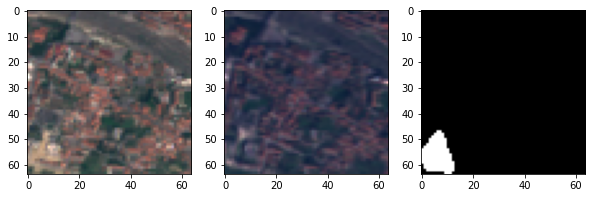

In [12]:
def show_three(im1,im2,lab):
    fig,ax = plt.subplots(1,3,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')

def show_four(im1,im2,lab,pred):
    fig,ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(lab[:,:,0], cmap='gray')
    ax[3].imshow(pred[:,:,0], cmap='gray')

def random_from_triplet(triplets):
    sample = np.random.randint(0,len(triplets[0]))
    print("#"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    #im1.shape,im2.shape,target.shape
    return im1,im2,lab

def show_rand_tripplet(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    show_three(im1,im2,lab)
    print(np.min(lab), np.max(lab))

show_rand_tripplet(train_triplets)

# 2 model

Total train ... im1: (1044, 64, 64, 3) im2: (1044, 64, 64, 3) lab: (1044, 64, 64, 1)
#269
0 1
Total test ... im1: (663, 64, 64, 3) im2: (663, 64, 64, 3) lab: (663, 64, 64, 1)
#98
0 0


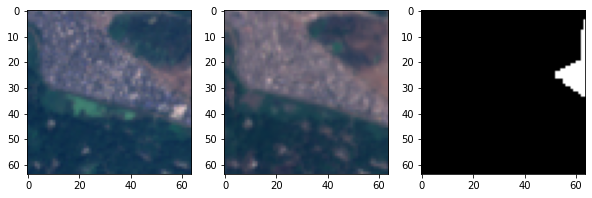

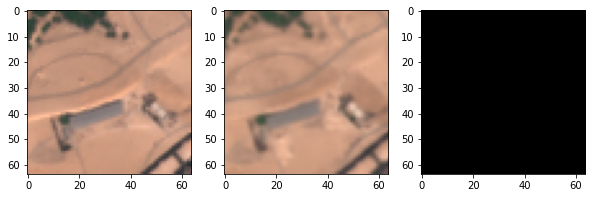

In [13]:
# Train
print("Total train ... im1:",train_triplets[0].shape, "im2:",train_triplets[1].shape, "lab:",train_triplets[2].shape)
show_rand_tripplet(train_triplets)
#Test
print("Total test ... im1:",test_triplets[0].shape, "im2:",test_triplets[1].shape, "lab:",test_triplets[2].shape)
show_rand_tripplet(test_triplets)

In [14]:
import segmentation_models as sm
#import keras
from tensorflow import keras

sm.set_framework('tf.keras') # for Collab ~
sm.framework()

keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [15]:
# Dataset:
## train_triplets, test_triplets => x_train, y_train, x_val, y_val

# dummy approach pixel differencing at the input!

def keras_dataset_differencingPixels(triplets):
    # input triples
    # outputs x, y
    train_im1, train_im2, train_labels = triplets
    print("in", train_im1.shape, train_im2.shape, train_labels.shape)

    x = train_im1 - train_im2
    y = train_labels
    
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    print("out", x.shape, y.shape, "types:", x.dtype, y.dtype)
    return x, y

x_train, y_train = keras_dataset_differencingPixels(train_triplets)
x_val, y_val = keras_dataset_differencingPixels(test_triplets)

in (1044, 64, 64, 3) (1044, 64, 64, 3) (1044, 64, 64, 1)
out (1044, 64, 64, 3) (1044, 64, 64, 1) types: float32 float32
in (663, 64, 64, 3) (663, 64, 64, 3) (663, 64, 64, 1)
out (663, 64, 64, 3) (663, 64, 64, 1) types: float32 float32


In [16]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
x_train, y_train, x_val, y_val

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet') # by default ,activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, 
             keras.metrics.AUC(
                  num_thresholds=200, curve='ROC',
                  summation_method='interpolation', name=None, dtype=None,
                  thresholds=None, multi_label=False, num_labels=None, label_weights=None,
                  from_logits=False
              )

             ],
)

85532672/85521592 [==============================] - 3s 0us/step


In [17]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=epochs,
   validation_data=(x_val, y_val),
)

Epoch 1/30
66/66 [==============================] - 38s 211ms/step - loss: 1.0694 - iou_score: 0.2225 - auc: 0.8123 - val_loss: 146195.8125 - val_iou_score: 0.0526 - val_auc: 0.5081
Epoch 2/30
66/66 [==============================] - 10s 159ms/step - loss: 0.8477 - iou_score: 0.3715 - auc: 0.9117 - val_loss: 1358.2611 - val_iou_score: 0.0194 - val_auc: 0.4991
Epoch 3/30
66/66 [==============================] - 10s 158ms/step - loss: 0.7802 - iou_score: 0.4259 - auc: 0.9253 - val_loss: 221.4138 - val_iou_score: 0.0397 - val_auc: 0.4983
Epoch 4/30
66/66 [==============================] - 11s 161ms/step - loss: 0.7528 - iou_score: 0.4460 - auc: 0.9299 - val_loss: 1.2721 - val_iou_score: 0.0056 - val_auc: 0.4969
Epoch 5/30
66/66 [==============================] - 10s 157ms/step - loss: 0.6925 - iou_score: 0.4897 - auc: 0.9389 - val_loss: 88.8594 - val_iou_score: 0.0509 - val_auc: 0.5015
Epoch 6/30
66/66 [==============================] - 10s 157ms/step - loss: 0.6003 - iou_score: 0.5582 - 

In [18]:
def predict_with_model_rand(triplets):
    im1,im2,lab = random_from_triplet(triplets)
    
    # Now predict with the model:
    x = im1 - im2
    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = lab.astype(np.float32)

    y_pred = model.predict(np.array( [x,] ))
    y_pred = y_pred[0]

    print("Prediction visualization")
    show_four(im1,im2,lab,y_pred)

In [19]:
# doesn't show useful details rly ...

#from keras.utils.vis_utils import plot_model
#plot_model(model, show_shapes=True)
#model.summary()

In [20]:
h = history.history
print(history.history.keys())

dict_keys(['loss', 'iou_score', 'auc', 'val_loss', 'val_iou_score', 'val_auc'])


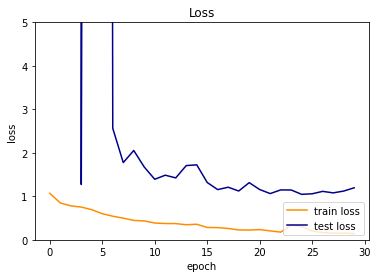

In [21]:
plt.figure()
plt.plot(h['loss'], color='darkorange', label='train loss')
plt.plot(h['val_loss'], color='darkblue', label='test loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_loss.png")
#plt.close()

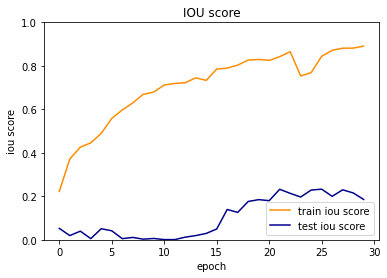

In [22]:
plt.figure()
plt.plot(h['iou_score'], color='darkorange', label='train iou score')
plt.plot(h['val_iou_score'], color='darkblue', label='test iou score')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('IOU score')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist_iou.png")
#plt.close()

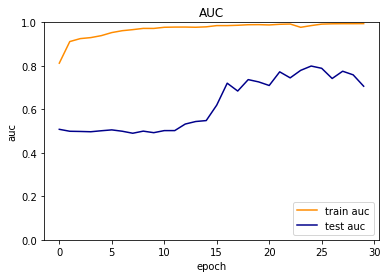

In [23]:
plt.figure()
plt.plot(h['auc'], color='darkorange', label='train auc')
plt.plot(h['val_auc'], color='darkblue', label='test auc')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('auc')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()
#plt.savefig(name+"hist.png")
#plt.close()

# 3a Evaluation

#271
Prediction visualization
#207
Prediction visualization
#303
Prediction visualization
#340
Prediction visualization


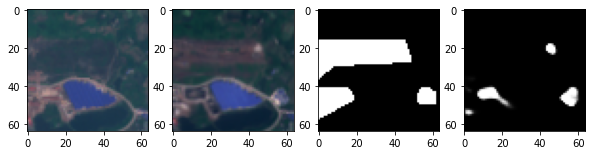

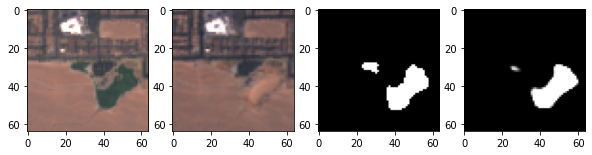

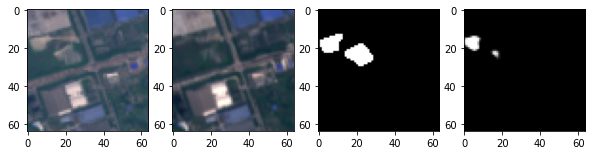

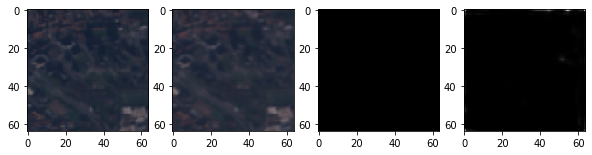

In [31]:
for _ in range(4):
  predict_with_model_rand(test_triplets)
  #predict_with_model_rand(train_triplets)

# Shows input 1 | input 2 | gt annotation | prediction

In [25]:
# from my repo ~ https://github.com/previtus/ChangeDetectionProject/blob/master/Evaluator.py

def calculate_auc_roc(predictions, ground_truths, name):
        # PS: arr_predictions might be needed non-thresholded!
        # performance of a binary classifier system as its discrimination threshold is varied
        unthresholded = predictions.flatten()
        arr_gts = ground_truths.flatten()

        auc = sklearn.metrics.roc_auc_score(arr_gts, unthresholded)
        # ROC AUC varies between 0 and 1 — with an uninformative classifier yielding 0.5

        # or a plot
        # sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(arr_gts, unthresholded, pos_label=None, sample_weight=None,
                                                         drop_intermediate=True)

        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        plt.savefig(name+"ROC_curveWith_AUC.png")
        plt.close()

        return auc

def calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=False, save_text_file=""):
        if len(predictions.shape) > 1:
            predictions_copy = np.array(predictions)
        else:
            predictions_copy = np.array([predictions])

        for image in predictions_copy:
            image[image >= threshold] = 1
            image[image < threshold] = 0

        arr_predictions = predictions_copy.flatten()
        arr_gts = ground_truths.flatten()

        sklearn_accuracy = sklearn.metrics.accuracy_score(arr_gts, arr_predictions)
        sklearn_precision = sklearn.metrics.precision_score(arr_gts, arr_predictions)
        sklearn_recall = sklearn.metrics.recall_score(arr_gts, arr_predictions)

        sklearn_f1 = 0.0
        if need_f1:
            sklearn_f1 = sklearn.metrics.f1_score(arr_gts, arr_predictions)

        if save_text_file is not "":
            labels = ["no change", "change"]  # 0 no change, 1 change
            text_report = str(sklearn.metrics.classification_report(arr_gts, arr_predictions, target_names=labels))
            text_report += "\n"
            text_report += str(sklearn.metrics.confusion_matrix(arr_gts, arr_predictions))

            print(text_report)
            print("saving to...", save_text_file)
            file = open(save_text_file, "w")
            file.write(text_report)
            file.close()

        return sklearn_recall, sklearn_precision, sklearn_accuracy, sklearn_f1



def predict_with_model_all(triplets):
    images1,images2,ground_truths = triplets
    
    # Now predict with the model:
    x = images1 - images2

    x = x.astype(np.float32)
    x = preprocess_input(x)
    y = ground_truths.astype(np.float32)
    
    predictions = model.predict(np.array( x ))

    """
    print("Prediction visualization")
    sample = np.random.randint(0,len(triplets[0]))
    print("Random sample #"+str(sample))
    im1,im2,lab = triplets[0][sample], triplets[1][sample], triplets[2][sample]
    y_pred = predictions[sample]
    show_four(im1,im2,lab,y_pred)
    """

    return predictions, ground_truths

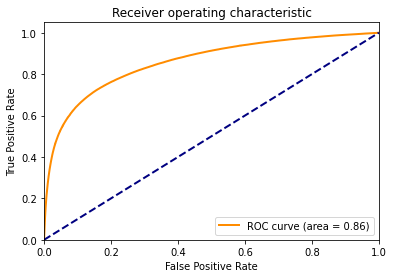

Finished with AUC (test set) = 0.8572633470358924
              precision    recall  f1-score   support

   no change       0.96      0.99      0.97   2569623
      change       0.57      0.29      0.39    146025

    accuracy                           0.95   2715648
   macro avg       0.77      0.64      0.68   2715648
weighted avg       0.94      0.95      0.94   2715648

[[2537332   32291]
 [ 103159   42866]]
saving to... test.txt
Recall 0.29355247389145694 Prec 0.5703527282887821 Acc 0.9501224017251131 F1 0.38760839489651056


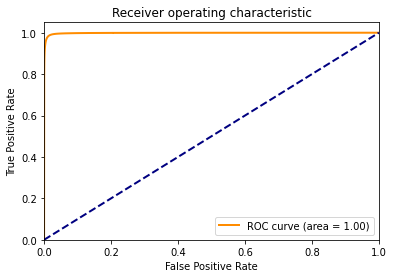

Finished with AUC (train set) = 0.9985851516475802
              precision    recall  f1-score   support

   no change       0.99      1.00      0.99   3826130
      change       0.97      0.94      0.96    450094

    accuracy                           0.99   4276224
   macro avg       0.98      0.97      0.98   4276224
weighted avg       0.99      0.99      0.99   4276224

[[3812702   13428]
 [  25216  424878]]
saving to... train.txt
Recall 0.9439761472048062 Prec 0.9693638690777676 Acc 0.9909630552562261 F1 0.9565015758667267


In [26]:
predictions, ground_truths = predict_with_model_all(test_triplets)

auc = calculate_auc_roc(predictions, ground_truths, "test")
print("Finished with AUC (test set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(predictions, ground_truths, threshold = 0.5, need_f1=True, save_text_file="test.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)

train_predictions, train_ground_truths = predict_with_model_all(train_triplets)
auc = calculate_auc_roc(train_predictions, train_ground_truths, "train")
print("Finished with AUC (train set) =",auc)
recall, precision, accuracy, f1 = calculate_recall_precision_accuracy(train_predictions, train_ground_truths, threshold = 0.5, need_f1=True, save_text_file="train.txt")
print("Recall",recall,"Prec",precision,"Acc",accuracy,"F1",f1)


# 3b Metrics comparable with other papers

In [27]:
# code snippet from https://github.com/rcdaudt/fully_convolutional_change_detection/blob/master/fully-convolutional-change-detection.ipynb
# edited for the current outputs

L = 1024

def kappa(tp, tn, fp, fn):
    N = tp + tn + fp + fn
    p0 = (tp + tn) / N
    pe = ((tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)) / (N * N)
    
    return (p0 - pe) / (1 - pe)

def test(triplets):
    predictions, ground_truths = predict_with_model_all(triplets)

    tot_loss = 0
    tot_count = 0
    tot_accurate = 0
    
    n = 2
    class_correct = list(0. for i in range(n))
    class_total = list(0. for i in range(n))
    class_accuracy = list(0. for i in range(n))
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    if True:
        ### predictions, ground_truths
        """
        c = (predictions.int() == ground_truths.int())
        for i in range(c.size(1)):
            for j in range(c.size(2)):
                l = int(ground_truths[0, i, j])
                class_correct[l] += c[0, i, j]
                class_total[l] += 1
        """
        tot_count += np.prod(ground_truths.shape)

        # Our net predicts <0 to 1> which makes sense to threshold at 0.5
        # The other code was likely predicting at - to + / or / 0 to non0

        #pr = (predictions.int() > 0) # maybe predictions are from -1 to +1 ? # or 0 and non0
        #gt = (ground_truths.int() > 0)
        pr = (predictions > 0.5)
        gt = (ground_truths > 0.5)

        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(np.logical_not(pr), np.logical_not(gt)).sum()
        fp += np.logical_and(pr, np.logical_not(gt)).sum()
        fn += np.logical_and(np.logical_not(pr), gt).sum()
        
    #net_loss = tot_loss/tot_count        
    #net_loss = float(net_loss.cpu().numpy())
    
    net_accuracy = 100 * (tp + tn)/tot_count
    
    #for i in range(n):
    #    class_accuracy[i] = 100 * class_correct[i] / max(class_total[i],0.00001)
    #    class_accuracy[i] =  float(class_accuracy[i].cpu().numpy())

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    dice = 2 * prec * rec / (prec + rec)
    prec_nc = tn / (tn + fn)
    rec_nc = tn / (tn + fp)
    
    pr_rec = [prec, rec, dice, prec_nc, rec_nc]
    
    k = kappa(tp, tn, fp, fn)
    
    return {    #'net_loss': net_loss, 
            'net_accuracy': net_accuracy, 
            'class_accuracy': class_accuracy, 
            'precision': prec, 
            'recall': rec, 
            'dice': dice, 
            'kappa': k}

results = test(test_triplets)
pprint(results)

{'class_accuracy': [0.0, 0.0],
 'dice': 0.38760839489651056,
 'kappa': 0.36438101349792723,
 'net_accuracy': 95.01224017251131,
 'precision': 0.5703527282887821,
 'recall': 0.29355247389145694}


**Compare:**

In [ ]:
assert False # stop here

In [ ]:
# Few notes:
# - When comparing the results from this colab with the paper's results ... keep in mind
#   that here we are tiling the test dataset and then considering the predictions, while in the original they evaluate the whole image at once.
#   There is some small difference if we ignored the last column / row of the image (when cutting it up into the smaller tiles).
#   However we do turn off overlap and filtering for the test set, so the numbers should be kinda representative of the paper's evaluation (except for the last column and row for each img...).

# - We used a super simple model - likely anything else would be better
# - We used only RGB channels without much preprocessing (div by 256 instead of proper per channel normalization)

In [ ]:
Finished with AUC (test set) = 0.8572633470358924
              precision    recall  f1-score   support

   no change       0.96      0.99      0.97   2569623
      change       0.57      0.29      0.39    146025   ### <<< precision, recall

    accuracy                           0.95   2715648   ### <<< net_accuracy
   macro avg       0.77      0.64      0.68   2715648
weighted avg       0.94      0.95      0.94   2715648

===

Recall 0.29355247389145694 Prec 0.5703527282887821 Acc 0.9501224017251131 F1 0.38760839489651056
### <<< Recall, Prec, Acc*10, F1 Score (Dice Coefficient)

===

{'class_accuracy': [0.0, 0.0],
 'dice': 0.38760839489651056, # = f1
 'kappa': 0.36438101349792723,
 'net_accuracy': 95.01224017251131,
 'precision': 0.5703527282887821, ### <<<
 'recall': 0.29355247389145694} ### <<<


In [ ]:
### (for reference) Run with filtered and overlapped test set ...

Finished with AUC (test set) = 0.8611822246734103
              precision    recall  f1-score   support

   no change       0.93      0.95      0.94   3313885
      change       0.62      0.52      0.57    524067   ### <<< precision, recall

    accuracy                           0.89   3837952   ### <<< net_accuracy
   macro avg       0.78      0.73      0.75   3837952
weighted avg       0.88      0.89      0.89   3837952


===

Recall 0.5192332278124744 Prec 0.624860498119308 Acc 0.8917862964414355 F1 0.5671708987071997
### <<< Recall, Prec, Acc*10, F1 Score (Dice Coefficient)

===

{'class_accuracy': [0.0, 0.0],
 'dice': 0.5671708987071997, # = f1
 'kappa': 0.505935621844957,
 'net_accuracy': 89.17862964414354,   ### <<< net_accuracy
 'precision': 0.624860498119308, ### <<<
 'recall': 0.5192332278124744}  ### <<<


In [ ]:
## For comparison
# the notebook at: https://github.com/rcdaudt/fully_convolutional_change_detection/blob/master/fully-convolutional-change-detection.ipynb
# finished with this score (keeping all the default parameters!):

{'class_accuracy': [96.7221908569336, 62.48452377319336],
 'dice': 0.5596700383480733, # = f1
 'kappa': 0.5333095421059931,
 'net_accuracy': 94.9709748301469,   ### <<< net_accuracy
 'net_loss': 0.28932735323905945,
 'precision': 0.5068069621145872, ### <<<
 'recall': 0.6248452303112088}  ### <<<

# Paper results (reported https://arxiv.org/pdf/1810.08462.pdf)
# Only RGB
#      Prec. Recall Global F1
# FC-EF 44.72 53.92  94.23 48.89

# All channels
#      Prec. Recall Global F1
# FC-EF 64.42 50.97  96.05 56.91

# Note paper and the other referential code uses:
# - uses all channels
# - uses rotations and flips for data augmentation
# - uses classes reweighting (more weight to change class)
# - uses the FresUNet (marked as "FC-EF-Res" in the later papers) from ~ https://github.com/rcdaudt/fully_convolutional_change_detection/blob/master/fresunet.py
